# HW 1 - DATA SCIENCE 2
## Adam Němec, Emma Kovalčíková

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from pathlib import Path

In [2]:
# set width of Jupyter notebook
from IPython.core.display import HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# set some visual properties of displaying pandas DataFrame
pd.options.display.max_columns=200
pd.options.display.max_rows=200

In [3]:
# Load data - set index column, decimal point, separator
data_file = Path("../Data/2024_DS2_HW1_data_train.csv")
data = pd.read_csv(data_file, sep = ',', decimal = '.', index_col = 'Booking_ID')

# print time of data being loaded - use strftime
print(f'Data loaded on:   {datetime.datetime.now().strftime(format="%Y-%m-%d %H:%M:%S")}')

Data loaded on:   2024-04-19 11:51:18


In [4]:
data.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
Booking_ID,,,,,,,,,,,,,,,,,,
INN10204,NaN,NaN,NaN,2.0,Meal Plan 2,NaN,Room_Type 6,NaN,2018.0,9.0,NaN,Online,0.0,0.0,NaN,NaN,1.0,0.0
INN20020,NaN,NaN,NaN,2.0,Meal Plan 1,NaN,NaN,NaN,NaN,12.0,NaN,Online,0.0,0.0,0.0,NaN,NaN,0.0
INN16435,1.0,NaN,NaN,2.0,NaN,0.0,Room_Type 1,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0,0.0
INN07143,3.0,NaN,NaN,3.0,NaN,NaN,NaN,100.0,2018.0,5.0,NaN,Online,0.0,0.0,NaN,NaN,2.0,0.0
INN20511,1.0,0.0,1.0,1.0,Meal Plan 1,0.0,NaN,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,0.0,150.0,NaN,1.0


In [5]:
# Print some numbers about data sample size
print(f'Number of rows:   {data.shape[0]:,}'.replace(',', ' '))
print(f'Number of unique indexes:   {data.index.nunique():,}'.replace(',', ' '))
print(f'Number of columns:   {data.shape[1]:,}'.replace(',', ' '))

data.booking_status.value_counts(dropna=False)

Number of rows:   32 647
Number of unique indexes:   32 647
Number of columns:   18


booking_status
0.0    21774
1.0    10521
NaN      352
Name: count, dtype: int64

In [6]:
# removing NA's from target
data=data.dropna(subset=['booking_status'])
print(f'Number of rows:   {data.shape[0]:,}'.replace(',', ' '))
data.booking_status.value_counts(dropna=False)

Number of rows:   32 295


booking_status
0.0    21774
1.0    10521
Name: count, dtype: int64

In [7]:
#name of the target column
col_target = "booking_status"

data['year'] = data['arrival_year'].fillna(0).astype(int).astype(str)
data['month'] = data['arrival_month'].fillna(0).astype(int).astype(str)
#data['date'] = data['arrival_date'].fillna(0).astype(int).astype(str)

# Pad date and month with leading zero if necessary
data['month'] = data['month'].apply(lambda x: x.zfill(2))
#data['date'] = data['date'].apply(lambda x: x.zfill(2))

# Combine 'year' and 'month' columns to form 'date' column
data['arrival'] = data['year'] + data['month'] #+ data['date']

# Replace 'date' values with NaN where 'year' or 'month' were NaN
data.loc[data['year'] == '0', 'arrival'] = float('nan')
data.loc[data['month'] == '00', 'arrival'] = float('nan')
#data.loc[data['date'] == '00', 'arrival'] = float('nan')

data.drop('year', axis=1, inplace=True)
data.drop('month', axis=1, inplace=True)
#data.drop('date', axis=1, inplace=True)

col_date = 'arrival'
#data.head()
#data['arrival']
data.arrival.value_counts(dropna=False)

arrival
NaN       3779
201810    2661
201806    2566
201809    2336
201808    2169
201804    2151
201805    2071
201807    1987
201811    1837
201803    1829
201812    1634
201710    1520
201802    1346
201709    1295
201708     799
201801     789
201712     717
201711     512
201707     297
Name: count, dtype: int64

In [8]:
data['sample'] = 'default'

# Separate NaN rows from the data
nan_indices = data[data[col_date].isna()].index
non_nan_data = data.dropna(subset=[col_date])
#non_nan_data.arrival_date.value_counts(dropna=False)

# Split the non-NaN data
data_train, data_rest = train_test_split(
    non_nan_data, 
    test_size=0.2, 
    random_state=1907, 
    stratify=non_nan_data[[col_date, col_target]]
)
data.loc[data_train.index, 'sample'] = 'train'

data_valid, data_test = train_test_split(
    data_rest, 
    test_size=0.5, 
    random_state=1907, 
    stratify=data_rest[[col_date, col_target]]
)
data.loc[data_test.index, 'sample'] = 'test'
data.loc[data_valid.index, 'sample'] = 'valid'

data_train_nan, data_rest_nan = train_test_split(
    data.loc[nan_indices], test_size=0.2, random_state=1907, stratify=data.loc[nan_indices][[col_target]]
)
data.loc[data_train_nan.index, 'sample'] = 'train'

data_valid_nan, data_test_nan = train_test_split(
    data_rest_nan, test_size=0.5, random_state=1907, stratify=data_rest_nan[[col_target]]
)
data.loc[data_test_nan.index, 'sample'] = 'test'
data.loc[data_valid_nan.index, 'sample'] = 'valid'

train_mask = (data['sample'] == 'train')
valid_mask = (data['sample'] == 'valid')
test_mask = (data['sample'] == 'test')

In [9]:
print(data[data['sample']=='train'].shape[0]/data.shape[0]) # ratio between train rows and all rows - checks
print(data[data['sample']=='test'].shape[0]/data.shape[0]) # ratio between test rows and all rows - checks
data[data['sample']=='valid'].shape[0]/data.shape[0] # ratio between valid rows and all rows - checks

0.7999690354544047
0.10001548227279765


0.10001548227279765

In [10]:
mapping = {0.0: 'No', 1.0: 'Yes'}

# Applying mapping and filling NaN with original NaN
data['required_car_parking_space'] = data['required_car_parking_space'].map(mapping)
data['repeated_guest'] = data['repeated_guest'].map(mapping)

print(data.required_car_parking_space.value_counts(dropna=False))
data.repeated_guest.value_counts(dropna=False)

required_car_parking_space
No     17077
NaN    14621
Yes      597
Name: count, dtype: int64


repeated_guest
NaN    24715
No      7383
Yes      197
Name: count, dtype: int64

In [11]:
cols_pred = list(data.columns[0:17])
cols_pred

# define list of numerical predictors
cols_pred_num = [col for col in cols_pred if data[col].dtype != 'O']
# define list of categorical predictors
cols_pred_cat = [col for col in cols_pred if data[col].dtype == 'O']

# potřeba upravit 0-1čkové?
print('Numerical predictors:')
print('---------------------')
print(data[cols_pred_num].dtypes)
print()
print('Categorical predictors:')
print('-----------------------')
print(data[cols_pred_cat].dtypes)

Numerical predictors:
---------------------
no_of_adults                            float64
no_of_children                          float64
no_of_weekend_nights                    float64
no_of_week_nights                       float64
lead_time                               float64
arrival_year                            float64
arrival_month                           float64
arrival_date                            float64
no_of_previous_cancellations            float64
no_of_previous_bookings_not_canceled    float64
avg_price_per_room                      float64
no_of_special_requests                  float64
dtype: object

Categorical predictors:
-----------------------
type_of_meal_plan             object
required_car_parking_space    object
room_type_reserved            object
market_segment_type           object
repeated_guest                object
dtype: object


In [12]:
def mean_target_encoding(dt, predictor, target, alpha = 0.01):
    total_cnt = len(dt)
    total_cr = np.mean(dt[target])
    dt_grp = dt.groupby(predictor).agg(
        categ_cr = (target, 'mean'),
        categ_cnt = (target, len)
    )
    
    dt_grp['categ_freq'] = dt_grp['categ_cnt'] / total_cnt
    dt_grp['categ_encoding'] = (dt_grp['categ_freq'] * dt_grp['categ_cr'] + alpha * total_cr) / (dt_grp['categ_freq'] + alpha)
    
    return dt_grp[['categ_encoding']].to_dict()['categ_encoding']

In [13]:
total_cr = np.mean(data[train_mask][col_target])

# encode categorical predictors
for pred in tqdm(cols_pred_cat):
    if len(data[pred].unique()) < 0:
        dummies = pd.get_dummies(
            data[pred], 
            prefix = pred,
            prefix_sep = '_',
            dummy_na = True if data[pred].isnull().sum() > 0 else False,
            drop_first = False
        )
        
        for d in dummies.columns:
            if d in data.columns:
                del data[d]
                
        data = data.join(dummies)
        
        for col in dummies.columns:
            if col not in cols_pred:
                cols_pred.append(col)
        
        if pred in cols_pred:
            cols_pred.remove(pred)
    else:
        new_vals = mean_target_encoding(
            dt=data[train_mask], 
            predictor=pred, 
            target=col_target
        )

        additional_values = set(data[data[pred].notnull()][pred].unique()) - set(new_vals.keys())
        for p in additional_values:
            new_vals[p] = total_cr

        data['MTE_' + pred] = data[pred].map(new_vals)
        
        if 'MTE_' + pred not in cols_pred:
            cols_pred.append('MTE_' + pred)
        
        if pred in cols_pred:
            cols_pred.remove(pred)

  0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
cols_pred

['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests',
 'MTE_type_of_meal_plan',
 'MTE_required_car_parking_space',
 'MTE_room_type_reserved',
 'MTE_market_segment_type',
 'MTE_repeated_guest']

In [15]:
booster_sklearn = xgb.XGBClassifier(
    booster='gbtree',
    objective='binary:logistic',
    random_state=1907,
    verbosity=1,
    eval_metric='auc',
    use_label_encoder=False,
    early_stopping_rounds=10,
    max_depth = 9,
    learning_rate = 0.045,
    n_estimators=10000
)

booster_sklearn.fit(
    data[train_mask][cols_pred].values, 
    data[train_mask][col_target].astype(int).values,
    eval_set=[
        (data[train_mask][cols_pred].values, data[train_mask][col_target].values),
        (data[test_mask][cols_pred].values, data[test_mask][col_target].values),
        (data[valid_mask][cols_pred].values, data[valid_mask][col_target].values),
    ],
    verbose=True,
)

[0]	validation_0-auc:0.79582	validation_1-auc:0.78197	validation_2-auc:0.77219
[1]	validation_0-auc:0.79872	validation_1-auc:0.78380	validation_2-auc:0.77635
[2]	validation_0-auc:0.79976	validation_1-auc:0.78430	validation_2-auc:0.77739
[3]	validation_0-auc:0.80096	validation_1-auc:0.78428	validation_2-auc:0.77936
[4]	validation_0-auc:0.80588	validation_1-auc:0.78704	validation_2-auc:0.78360
[5]	validation_0-auc:0.80558	validation_1-auc:0.78777	validation_2-auc:0.78337
[6]	validation_0-auc:0.80783	validation_1-auc:0.78823	validation_2-auc:0.78564
[7]	validation_0-auc:0.80931	validation_1-auc:0.78896	validation_2-auc:0.78669
[8]	validation_0-auc:0.80959	validation_1-auc:0.78872	validation_2-auc:0.78682
[9]	validation_0-auc:0.81089	validation_1-auc:0.79028	validation_2-auc:0.78805
[10]	validation_0-auc:0.81133	validation_1-auc:0.79092	validation_2-auc:0.78854
[11]	validation_0-auc:0.81290	validation_1-auc:0.79137	validation_2-auc:0.79061
[12]	validation_0-auc:0.81309	validation_1-auc:0.7

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.045, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10000, n_jobs=None,
              num_parallel_tree=None, random_state=1907, ...)

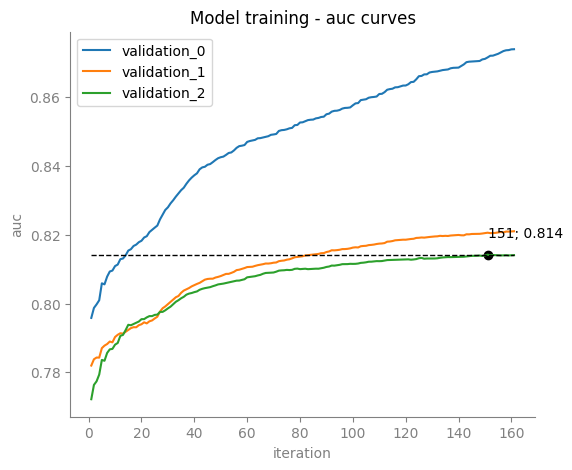

In [16]:
metric = 'auc'
evals_result = booster_sklearn.evals_result()
fig = plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1)
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    ax.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster_sklearn.best_score
best_iteration = booster_sklearn.best_iteration+1

ax.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
ax.scatter([best_iteration], [best_score], color = 'black')
ax.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
)
ax.set_xlabel('iteration', color='gray')
ax.set_ylabel(metric, color='gray')
ax.legend(loc='best')
ax.set_title(f'Model training - {metric} curves')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

# plt.savefig('test.svg', format='svg')
# plt.close()

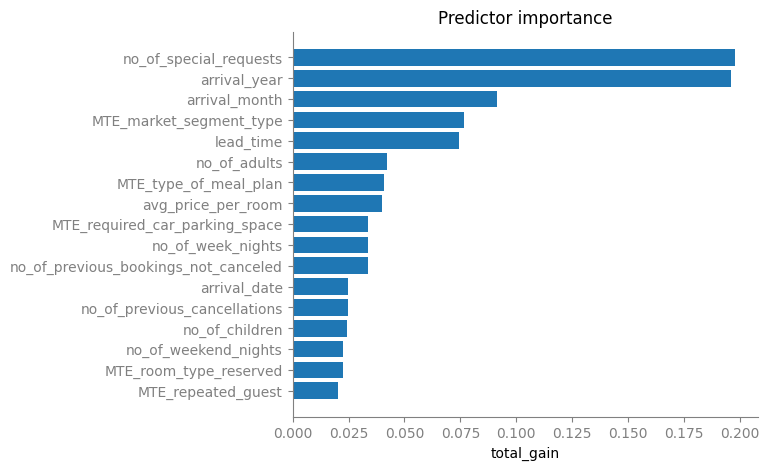

In [17]:
outcomes = dict(zip(cols_pred,booster_sklearn.feature_importances_)).items()

importance_type = 'total_gain'

predictor_strength = sorted([(k, v) for k,v in outcomes], key = lambda x: x[1], reverse = True)
predictor_strength = pd.DataFrame(predictor_strength, columns = ['predictor', 'strength'])

fig = plt.figure(figsize=(6,5))

n_strongest = 17
plt.barh(range(n_strongest, 0, -1), predictor_strength['strength'].iloc[0:17])
plt.yticks(range(n_strongest, 0, -1), predictor_strength['predictor'].iloc[0:17])
plt.xlabel(importance_type)
plt.title('Predictor importance')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

plt.show()

# SHAP

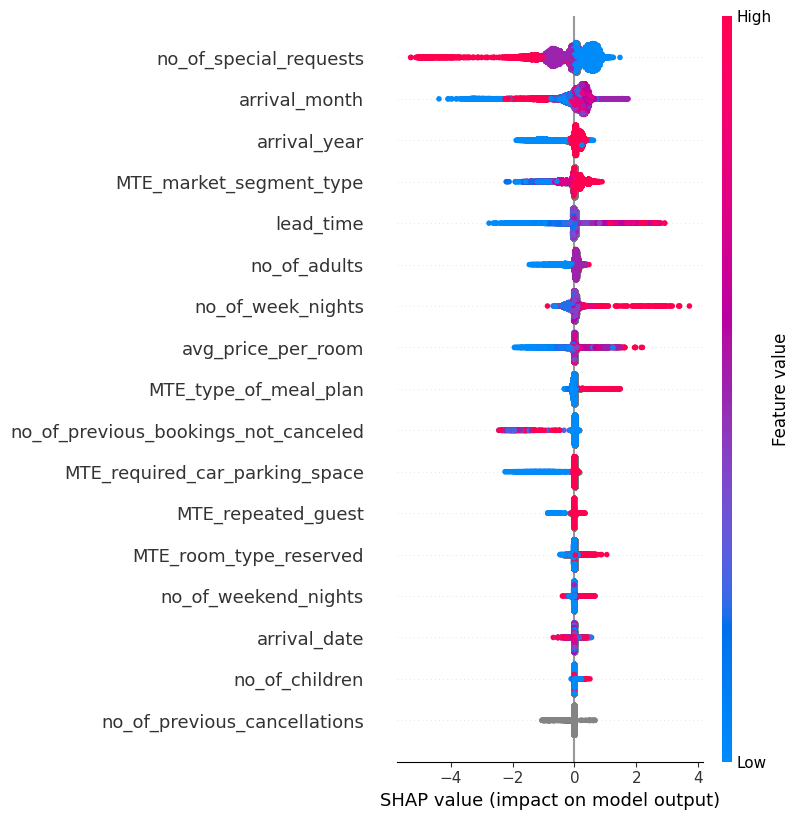

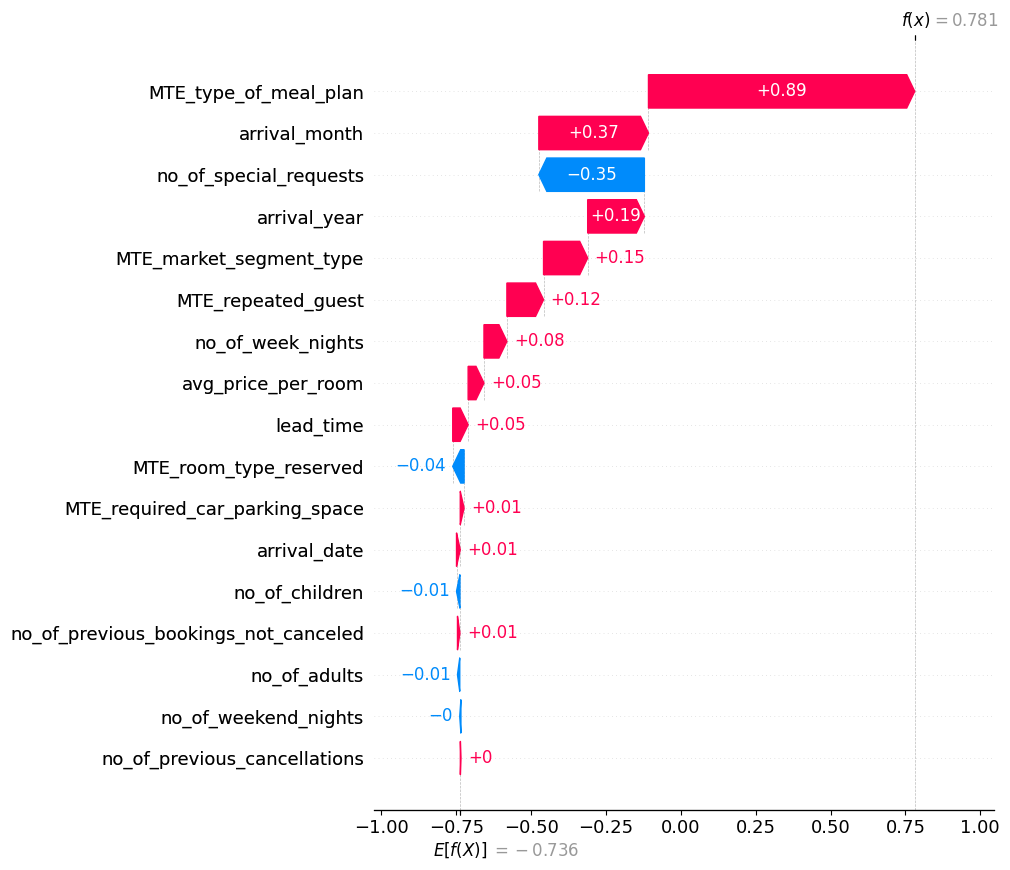

In [18]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(booster_sklearn)
shap_values = explainer.shap_values(data[cols_pred])

plt.figure()
shap.summary_plot(shap_values, data[cols_pred], max_display=20, show=True)
plt.show()

shap.force_plot(explainer.expected_value, shap_values[0,:], data[cols_pred].iloc[0,:])

shap.plots._waterfall.waterfall_legacy(
    expected_value=explainer.expected_value, 
    shap_values=shap_values[0, :], 
    feature_names=cols_pred, 
    max_display=20
)

# Top 10 predictors

In [19]:
cols_pred_top10 = [x for x in cols_pred if (x not in list(dict(sorted([(k, v) for k,v in outcomes], key = lambda x: x[1], reverse = True)[-7:]).keys()))]

In [33]:
for i in range(5,13):
    for j in range(4,21):
        booster_sklearn_top10 = xgb.XGBClassifier(
            booster='gbtree',
            objective='binary:logistic',
            random_state=1907,
            verbosity=1,
            eval_metric='auc',
            use_label_encoder=False,
            early_stopping_rounds=20,
            max_depth = i,
            learning_rate = j/200,
            n_estimators=10000
        )
                
        booster_sklearn_top10.fit(
            data[train_mask][cols_pred_top10].values, 
            data[train_mask][col_target].astype(int).values,
            eval_set=[
                (data[train_mask][cols_pred_top10].values, data[train_mask][col_target].values),
                (data[test_mask][cols_pred_top10].values, data[test_mask][col_target].values),
                (data[valid_mask][cols_pred_top10].values, data[valid_mask][col_target].values),
            ],
            verbose=False,
        )
        print(i)
        print(j/200)
        print(booster_sklearn_top10.best_score)
        print("------")

5
0.02
0.8121915200496708
------
5
0.025
0.8139436425661346
------
5
0.03
0.8123646176331064
------
5
0.035
0.8140251771961157
------
5
0.04
0.8153757307595714
------
5
0.045
0.8122861351015739
------
5
0.05
0.8127470019672954
------
5
0.055
0.8116768054470365
------
5
0.06
0.8148433575873424
------
5
0.065
0.8158222091611788
------
5
0.07
0.8134276199213082
------
5
0.075
0.8146063839435205
------
5
0.08
0.8140443618149347
------
5
0.085
0.8139347042778212
------
5
0.09
0.8159190042834021
------
5
0.095
0.8140574422368568
------
5
0.1
0.8118287563483648
------
6
0.02
0.8156979451529188
------
6
0.025
0.8156471495144547
------
6
0.03
0.815999230871191
------
6
0.035
0.8145381477424936
------
6
0.04
0.81616840432805
------
6
0.045
0.8156037661150798
------
6
0.05
0.816236858536109
------
6
0.055
0.8153510959649515
------
6
0.06
0.8163048767301038
------
6
0.065
0.817000537169327
------
6
0.07
0.8140356415336533
------
6
0.075
0.816112158513785
------
6
0.08
0.8160035910118317
------
6
0

In [ ]:
metric = 'auc'
evals_result = booster_sklearn_top10.evals_result()
fig = plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1)
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    ax.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster_sklearn_top10.best_score
best_iteration = booster_sklearn_top10.best_iteration+1

ax.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
ax.scatter([best_iteration], [best_score], color = 'black')
ax.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
)
ax.set_xlabel('iteration', color='gray')
ax.set_ylabel(metric, color='gray')
ax.legend(loc='best')
ax.set_title(f'Model training - {metric} curves')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

# plt.savefig('test.svg', format='svg')
# plt.close()

# Kaggle 

In [ ]:
# Load data - set index column, decimal point, separator
data_file = Path("../Data/2024_DS2_HW1_data_test.csv")
data_kaggle = pd.read_csv(data_file, sep = ',', decimal = '.', index_col = 'Booking_ID')

# print time of data being loaded - use strftime
print(f'Data loaded on:   {datetime.datetime.now().strftime(format="%Y-%m-%d %H:%M:%S")}')

In [ ]:
data_kaggle

In [ ]:
mapping = {0.0: 'No', 1.0: 'Yes'}
data_kaggle['required_car_parking_space'] = data_kaggle['required_car_parking_space'].map(mapping)
data_kaggle['repeated_guest'] = data_kaggle['repeated_guest'].map(mapping)

In [ ]:
mapping = {'Meal Plan 2': 0.42427875, 'Meal Plan 1': 0.31318309, 'Not Selected': 0.32798397, 'Meal Plan 3': 0.32713655}
data_kaggle['MTE_type_of_meal_plan'] = data_kaggle['type_of_meal_plan'].map(mapping)

In [ ]:
mapping = {'No': 0.33087411, 'Yes': 0.17847759}
data_kaggle['MTE_required_car_parking_space'] = data_kaggle['required_car_parking_space'].map(mapping)

In [ ]:
values = np.array([0.3753117 , 0.3236826 , 0.33434192, 0.33716962, 0.30454475, 0.31249378, 0.32454212])
labels = np.array(['Room_Type 6', 'Room_Type 1', 'Room_Type 4', 'Room_Type 2', 'Room_Type 5', 'Room_Type 7', 'Room_Type 3'])

mapping = {label: value for value, label in zip(values, labels)}

data_kaggle['MTE_room_type_reserved'] = data_kaggle['room_type_reserved'].map(mapping)

In [ ]:
values = np.array([0.36570619, 0.30665983, 0.31718622, 0.19558499, 0.15711683])
labels = np.array(['Online', 'Offline', 'Aviation', 'Complementary', 'Corporate'])

mapping = {label: value for value, label in zip(values, labels)}

data_kaggle['MTE_market_segment_type'] = data_kaggle['market_segment_type'].map(mapping)

In [ ]:
values = np.array([0.34306786, 0.20499584])
labels = np.array(['No','Yes'])

mapping = {label: value for value, label in zip(values, labels)}

data_kaggle['MTE_repeated_guest'] = data_kaggle['repeated_guest'].map(mapping)

In [ ]:
data_kaggle.head()

In [ ]:
#predictions_sklearn = booster_sklearn.predict_proba(data_kaggle[cols_pred],iteration_range=(0,booster_sklearn.best_iteration))
#print(predictions_sklearn[:, 1])

predictions_sklearn_top10 = booster_sklearn_top10.predict_proba(data_kaggle[cols_pred_top10],iteration_range=(0,booster_sklearn_top10.best_iteration))
print(predictions_sklearn_top10[:, 1])

In [ ]:
csv_file = 'solution.csv'

pred_data = {
    'Booking_ID': data_kaggle.index,
    'booking_status': predictions_sklearn_top10[:, 1],
}
# Creating a DataFrame
df = pd.DataFrame(pred_data)

# File path to save the CSV
csv_file = 'solution.csv'

# Writing to the CSV file
df.to_csv(csv_file, index=False)

print("CSV file generated successfully.")